## 3. Flow data discretization task
We aim to learn a sequential model from NetFlow data from an infected host (unidirectional netfows). Consider scenario 10 from the CTU-13 data sets (see paper 4 from below resources). **Remove all background flows from the data**. You are to discretize the NetFlows. **Investigate the data from one of the infected hosts**. **Select and visualize two features that you believe are most relevant for modeling the behavior of the infected host**. **Discretize these features** using use any of the methods discussed in class (combine the two values into a single discrete value). Do you observe any behavior in the two features that could be useful for detecting the infection? Explain. Apply the discretization to data from all hosts in the selected scenario.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
#pre-process, divide raw data in to follwing coulmns: Data, Duration, Protocol, Source, Destination and Label
columns=['Date','Duration','Protocol','Source','Dest','Packet','Bytes','Label']
lst=[]
with open("capture20110818.pcap.netflow.labeled") as fp:  
    for cnt, line in enumerate(fp):
        if cnt!=0:
            dat=line.split()
            lst.append([dat[0]+' '+dat[1],dat[2],dat[3],dat[4].split(':')[0],dat[6].split(':')[0],dat[9],dat[10],dat[12]])
dataset=pd.DataFrame(lst, columns=columns)

In [28]:
dataset.head()

,Date,Duration,Protocol,Source,Dest,Packet,Bytes,Label
0,2011-08-18 10:19:13.328,0.002,TCP,147.32.86.166,212.24.150.110,4,321,Background
1,2011-08-18 10:19:13.328,4.995,UDP,82.39.2.249,147.32.84.59,617,40095,Background
2,2011-08-18 10:19:13.329,4.996,UDP,147.32.84.59,82.39.2.249,1290,1909200,Background
3,2011-08-18 10:19:13.330,0.000,TCP,147.32.86.166,147.32.192.34,1,66,Background
4,2011-08-18 10:19:13.330,0.000,TCP,212.24.150.110,147.32.86.166,2,169,Background


### 3.1 Process dataset

In [29]:
print(f'before remove background, length is : {len(dataset)}')
#remove backgroundflow
dataset_clean = dataset.loc[(dataset['Label']!="Background")]
# dataset_clean=dataset_clean[dataset_clean['Packet'].astype(str).str.isdigit()]
dataset_clean = dataset_clean.reset_index(drop=True)
print(f'before after background, length is : {len(dataset_clean)}')
#change Date to pandas form
dataset_clean['Date'] = pd.to_datetime(dataset_clean['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
#fill NAN values using 0
dataset_clean['Duration']=dataset_clean['Duration'].fillna(0)
dataset_clean['Label']=dataset_clean['Label'].fillna(0)
#convert several columns to numerical
dataset_clean['Duration']=pd.to_numeric(dataset_clean['Duration'])
dataset_clean['Packet']=pd.to_numeric(dataset_clean['Packet'])
dataset_clean['Bytes']=pd.to_numeric(dataset_clean['Bytes'])
#map Label to numbers. botnet is represented by 0 and the rest by 1
for index, i in enumerate(dataset_clean['Label']):
    if i == 'Botnet':
        val=0
    else:
        val = 1
    dataset_clean.set_value(index,'Label',val)

before remove background, length is : 5180851
before after background, length is : 645358
                      Date Duration Protocol         Source            Dest  \
0  2011-08-18 10:19:13.347    4.985      TCP   147.32.80.13    147.32.85.88   
1  2011-08-18 10:19:13.392    0.000      TCP  147.32.86.110  74.125.232.214   
2  2011-08-18 10:19:13.411    4.921      TCP   147.32.85.88    147.32.80.13   
3  2011-08-18 10:19:13.460    4.742      TCP   147.32.84.59  74.125.108.208   
4  2011-08-18 10:19:13.486    0.000      TCP   147.32.84.59  74.125.232.215   

  Packet  Bytes       Label  
0     91  86277  LEGITIMATE  
1      1     66  LEGITIMATE  
2     49   3234  LEGITIMATE  
3    118   7080  LEGITIMATE  
4      1     60  LEGITIMATE  
                     Date Duration Protocol         Source            Dest  \
0 2011-08-18 10:19:13.347    4.985      TCP   147.32.80.13    147.32.85.88   
1 2011-08-18 10:19:13.392    0.000      TCP  147.32.86.110  74.125.232.214   
2 2011-08-18 10:19:13

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [30]:
print(np.unique(dataset_clean['Label']))
dataset_clean.head()

[0 1]


,Date,Duration,Protocol,Source,Dest,Packet,Bytes,Label
0,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,147.32.85.88,91,86277,1
1,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,74.125.232.214,1,66,1
2,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,147.32.80.13,49,3234,1
3,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,74.125.108.208,118,7080,1
4,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,74.125.232.215,1,60,1


### 3.2 Investigate infected host

In [31]:
# investigate  infected host
infected_host = '147.32.84.208'
dataset_infected = dataset_clean.loc[(dataset_clean['Source']==infected_host) | (dataset_clean['Dest']==infected_host)]
dataset_infected = dataset_infected.reset_index()
print(f'length of ingected dataset is {len(dataset_infected)}')

length of ingected dataset is 33723


In [32]:
dataset_infected.head()

,index,Date,Duration,Protocol,Source,Dest,Packet,Bytes,Label
0,1390,2011-08-18 10:20:40.906,0.0,TCP,58.188.108.203,147.32.84.208,1,66,0
1,42847,2011-08-18 11:01:02.018,0.0,UDP,147.32.84.208,147.32.80.9,1,64,0
2,42848,2011-08-18 11:01:02.018,0.0,UDP,147.32.80.9,147.32.84.208,1,139,0
3,42881,2011-08-18 11:01:04.267,0.0,UDP,147.32.84.208,147.32.80.9,1,87,0
4,42882,2011-08-18 11:01:04.268,0.0,UDP,147.32.80.9,147.32.84.208,1,503,0


### 3.3 Visualize the features

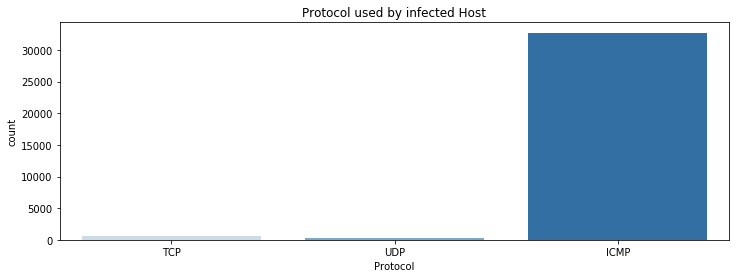

<Figure size 432x288 with 0 Axes>

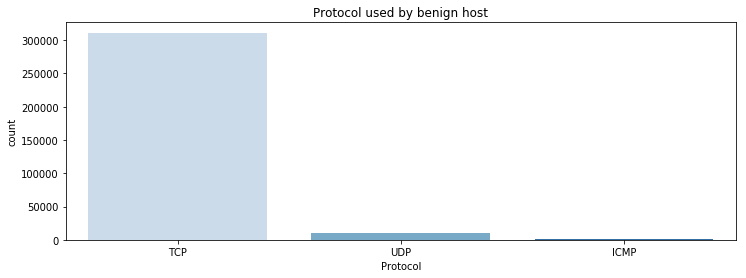

In [33]:
#plot the protocol used by the infected host
figure(figsize=(12,4))
plt.title('Protocol used by infected Host')
sns.countplot(x="Protocol", data=dataset_infected, palette="Blues")
plt.figure()
#plot the protocol used by benign host
figure(figsize=(12,4))
plt.title('Protocol used by benign host')
dataset_normal=dataset_clean.loc[dataset_clean['Label']==1]
sns.countplot(x="Protocol", data=dataset_normal, palette="Blues")

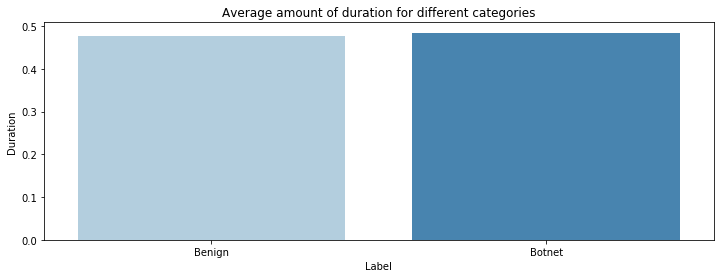

In [34]:
#plot the averaged duration used by infected hosts and benign hosts
Average=[]
dataset_normal=dataset_clean.loc[dataset_clean['Label']==1]
tmp1=dataset_normal['Duration'].tolist()
tmp2=list(map(int, tmp1))
Average.append(np.mean(tmp2))
malware=dataset_clean.loc[dataset_clean['Label']==0]
tmp1=malware['Duration'].tolist()
tmp2=list(map(int, tmp1))
Average.append(np.mean(tmp2))
labels = ('Benign', 'Botnet')
average_frame = {'Label': labels, 'Duration': Average }
average_frame = pd.DataFrame(average_frame)
figure(figsize=(12,4))
plt.title('Average amount of duration for different categories')
sns.barplot(x='Label', y = 'Duration', palette='Blues', data= average_frame)

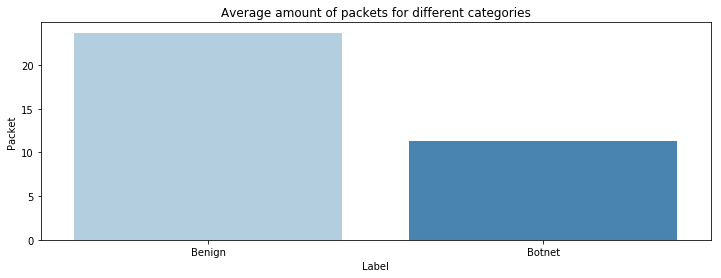

In [35]:
#plot the averaged bytes used by infected hosts and benign hosts
Packet=[]
dataset_normal=dataset_clean.loc[dataset_clean['Label']==1]
tmp1=dataset_normal['Packet'].tolist()
tmp2=list(map(int, tmp1))
Packet.append(np.mean(tmp2))
malware=dataset_clean.loc[dataset_clean['Label']==0]
tmp1=malware['Packet'].tolist()
tmp2=list(map(int, tmp1))
Packet.append(np.mean(tmp2))
labels = ('Benign', 'Botnet')
packet_frame = {'Label': labels, 'Packet': Packet }
packet_frame = pd.DataFrame(packet_frame)
figure(figsize=(12,4))
plt.title('Average amount of packets for different categories')
sns.barplot(x='Label', y = 'Packet', palette='Blues', data= packet_frame)

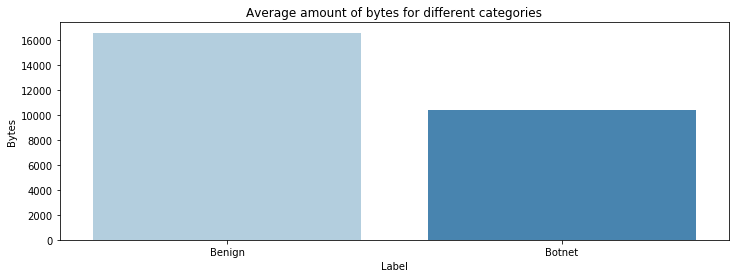

In [36]:
#plot the averaged bytes used by infected hosts and benign hosts
Bytes=[]
dataset_normal=dataset_clean.loc[dataset_clean['Label']==1]
tmp1=dataset_normal['Bytes'].tolist()
tmp2=list(map(int, tmp1))
Bytes.append(np.mean(tmp2))
malware=dataset_clean.loc[dataset_clean['Label']==0]
tmp1=malware['Bytes'].tolist()
tmp2=list(map(int, tmp1))
Bytes.append(np.mean(tmp2))
labels = ('Benign', 'Botnet')
bytes_frame = {'Label': labels, 'Bytes': Bytes }
bytes_frame = pd.DataFrame(bytes_frame)
figure(figsize=(12,4))
plt.title('Average amount of bytes for different categories')
sns.barplot(x='Label', y = 'Bytes', palette='Blues', data= bytes_frame)

### 3.4 Discritization

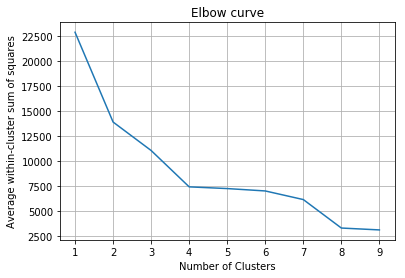

In [37]:
#calculate number of clusters used  using elbow
def elbow (data):
    dist = []
    X=data.values.reshape(-1,1)
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        dist.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.plot(range(1, 10), dist)
    plt.title('Elbow rule')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.grid(True)
    plt.title('Elbow curve')
elbow(dataset_clean['Bytes'])

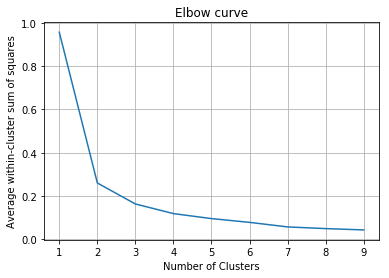

In [38]:
elbow(dataset_clean['Duration'])

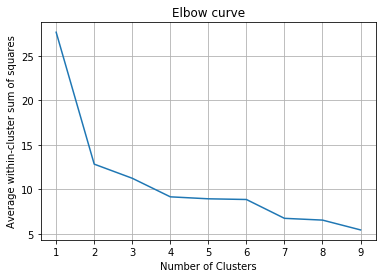

In [49]:
elbow(dataset_clean['Packet'])

In [40]:
#functions for encoding
def ordinal_rank(bins,col_name):
    percentile = int(100/bins)
    split_list = []

    for p in range(percentile, 99, percentile):
        rank = math.ceil((p/100.0)*len(dataset_clean[col_name])*1.0)
        val = sorted(dataset_clean[col_name])[int(rank)]
        split_list.append(val)
    return split_list

def attribute_mapping(x, split_list):
    for i,s in enumerate(split_list):
        if x<=s:
            return i
    return len(split_list)

def netflow_encoding(netflow, feature_space):
    code = 0
    space_size = feature_space[0]*feature_space[1]
    for i in range (0,len(feature_space)):
        code = code + (netflow[i]) * space_size / feature_space[i]
        space_size = space_size / feature_space[i]
    return code

In [41]:
split_list_Packets = ordinal_rank(4,'Packet')
d_discr_infected = pd.DataFrame()
d_discr_infected['Packet'] = dataset_infected['Packet'].apply(lambda x: attribute_mapping(x,split_list_Packets))
d_discr_infected['Protocol'] = pd.factorize(dataset_infected['Protocol'])[0]
feature_space = [d_discr_infected[name].nunique() for name in d_discr_infected.columns[0:2]]
d_discr_infected['code'] = d_discr_infected.apply(lambda x: netflow_encoding(x, feature_space),axis=1)

d_discr_normal = pd.DataFrame()
d_discr_normal['Packet'] = dataset_normal['Packet'].apply(lambda x: attribute_mapping(x,split_list_Packets))
d_discr_normal['Protocol'] = pd.factorize(dataset_normal['Protocol'])[0]
feature_space = [d_discr_normal[name].nunique() for name in d_discr_normal.columns[0:2]]
d_discr_normal['code'] = d_discr_normal.apply(lambda x: netflow_encoding(x, feature_space),axis=1)

d_discr = pd.DataFrame()
d_discr['Packet'] = dataset_clean['Packet'].apply(lambda x: attribute_mapping(x,split_list_Packets))
d_discr['Protocol'] = pd.factorize(dataset_clean['Protocol'])[0]
feature_space = [d_discr[name].nunique() for name in d_discr.columns[0:2]]
d_discr['code'] = d_discr.apply(lambda x: netflow_encoding(x, feature_space),axis=1)
dataset_clean['code'] = d_discr['code']
d_discr['Source'] = dataset_clean['Source']
d_discr['Dest'] = dataset_clean['Dest']
d_discr['StartTime'] = dataset_clean['Date']

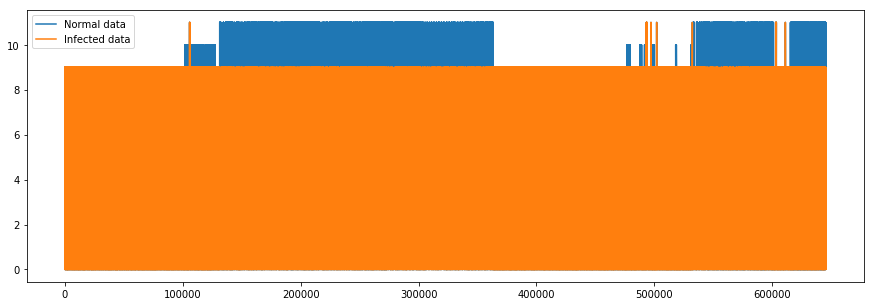

In [42]:
plt.figure(figsize=(15,5))
plt.plot(d_discr['code'], label="Normal data")
plt.plot(d_discr_normal['code'], label="Infected data")
plt.legend()
plt.show()

## 4. Profiling task

In [43]:
def extract_state(host_data,width):
    start_time = host_data['StartTime']
    difference_list = []
    for i in range(len(host_data)):
        if i == 0:
            difference = 0
        else:
            difference = start_time.iloc[i]-start_time.iloc[i-1]
            difference = np.ceil(difference.value/1e6)
        difference_list.append(difference)
    host_data['time'] = difference_list
            
    # sliding window
    state_list = []
    for i in range(len(host_data)):
        j = i
        state_list.append([])
        temp_list = [host_data['code'].iloc[j]]
        time_sum = 0
        while True:
            try:
                time_sum += difference_list[j+1]
            except:
                break
            j += 1
            if time_sum<=width:
                temp_list.append(host_data['code'].iloc[j])
            else:
                break
        if len(temp_list)>=3:
            state_list[i] = temp_list
    host_data['window_states'] = state_list
    return host_data

In [44]:
# apply the n-grams
def find_ngrams(states, n):
    ngrams = []
    for state in states:
        for s in range(len(state)-n+1):
            ngrams.append(state[s:s+n])    
    return ngrams

def sort_ngrams(grams3_normals):
    ngram_dict = {}
    for gram in grams3_normals :
        grams = str(gram)[1:-1]
        if grams in ngram_dict:
            ngram_dict[grams] += 1
        else:
            ngram_dict[grams] = 1 
    sorted_ngrams = sorted(ngram_dict.items(),key = lambda x:x[1], reverse = True )
    sortedgrams_normed = [ (list[0], 1.0*list[1]/len(grams3_normals)) for list in sorted_ngrams]
    return sortedgrams_normed

In [45]:
#Select an IP for training and the rest for testing
# we define one normal host as "train" set
# for the botnet we will used the infected_host defined above
normal_host = '147.32.84.170'

test_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204',
             '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.209', '147.32.84.134', 
              '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

In [46]:
# train on normal host
train_normal = d_discr[(d_discr['Source'] == normal_host) | (d_discr['Dest'] == normal_host)]
train_normal_states = extract_state(train_normal, width=90)
train_normal_states = [l for l in train_normal_states['window_states'] if len(l)>0]
train_normal_ngrams = find_ngrams(train_normal_states, 2)
train_normal = sort_ngrams(train_normal_ngrams)


# train on infected host(the same infected host as above in task3)
train_infected = d_discr[(d_discr['Source'] == infected_host) | (d_discr['Dest'] == infected_host)]
train_infected_states = extract_state(train_infected, width=90)
train_infected_states = [l for l in train_infected_states['window_states'] if len(l)>0]
train_infected_ngrams = find_ngrams(train_infected_states, 2)
train_infected = sort_ngrams(train_infected_ngrams)

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
from sklearn.metrics import confusion_matrix
def fingerprint_matching(finger_train, finger_test, topN):
    finger_train = finger_train[0:topN]
    freq_train = [pair[1] for pair in finger_train]
    
    finger_test = {pair[0]:pair[1] for pair in finger_test}
    fre_test = []
    for i in range(topN):
        key = finger_train[i][0]
        if key in finger_test:
            fre_test.append(finger_test[key])
        else:
            fre_test.append(0)  
    dis = distance(freq_train,fre_test)
    return dis

def distance(finger_train, finger_test):
    finger_train = np.array(finger_train)
    finger_test = np.array(finger_test)
    dis = sum((np.divide((finger_train-finger_test),(finger_train+finger_test)/2))**2)
    return dis

fmatch_test= np.zeros((len(test_hosts),2))

for index, host in enumerate(test_hosts):
    test_data = d_discr[(d_discr['Source'] == host) | (d_discr['Dest'] == host)]
    test_states = extract_state(test_data,width=90)
    test_states = [l for l in test_states['window_states'] if len(l)>0]
    test_ngrams = find_ngrams(test_states, 2)
    test_fingerprint = sort_ngrams(test_ngrams)
    fmatch_test[index][0] = fingerprint_matching(train_infected,test_fingerprint,10)    
    fmatch_test[index][1] = fingerprint_matching(train_normal,test_fingerprint,10)   
    
test_label = np.zeros(14)
for i in range(14):
        if fmatch_test[i][0] <= fmatch_test[i][1]:
            test_label[i] = 1
        else:
            test_label[i] = 0

true_label = [1,1,1,1,1,1,1,1,1,0,0,0,0,0]

tn, fp, fn, tp = confusion_matrix(test_label, true_label).ravel()

print(f"TN {tn}")
print(f"FP {fp}")
print(f"FN {fn}")
print(f"TP {tp}")
print(f"'precision:', {float(tp)/(tp+fp)}") 
print(f"'recall', {float(tp)/(tp+fn)}")

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TN 4
FP 0
FN 1
TP 9
'precision:', 1.0
'recall', 0.9
